## LOADING A CLUSTER MODEL

In [660]:

import pickle
pkl_filename = 'pickle_model.pkl'


# Load from file
with open(pkl_filename, 'rb') as file:
    print(file)
    pickle_model = pickle.load(file)

<_io.BufferedReader name='pickle_model.pkl'>


## Imports



In [661]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

import PIL.ImageOps  
from PIL import Image

import torch
import torchvision
import torch.nn as nn
from torch import optim
import torchvision.utils
import torch.nn.functional as F
from torch.autograd import Variable  
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

## Helper functions
Set of helper functions

In [662]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

## Configuration Class


In [663]:
class Config():
    training_dir = "/PES Indian Faces Dataset/PES_Indian_Faces_Data/Training/"
    validation_dir = "/PES Indian Faces Dataset/PES_Indian_Faces_Data/Validation/"
    testing_dir = "/PES Indian Faces Dataset/PES_Indian_Faces_Data/Testing/"

## Using Image Folder Dataset

In [664]:
folder_dataset = dset.ImageFolder(root=Config.testing_dir)

## Neural Net Definition
We will use a standard convolutional neural network

In [665]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 128)) # 5 features, 128 features

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1) # flattening .. connect to fully connected layer
        output = self.fc1(output)
        return output

    def forward(self, input1, input2): # invoked automatically when you pass an image to object
        output1 = self.forward_once(input1)
        #capture those 128 features of image1
        output2 = self.forward_once(input2)
        #capture those 128 featues of image2
        return output1, output2

## LOADING SIAMESE NETWORK MODEL

In [666]:
model = SiameseNetwork()
model.load_state_dict(torch.load("model.pth"))
model.eval() 

SiameseNetwork(
  (cnn1): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU(inplace=True)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReflectionPad2d((1, 1, 1, 1))
    (9): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU(inplace=True)
    (11): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Sequential(
    (0): Linear(in_features=80000, out_features=500, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=500, out_features=128, bias=True)
  )
)

## FINDING THE SIMILAR IMAGES

## CALCULATING SIMILARITIES

In [667]:
img0_tuple = random.choice(folder_dataset.imgs)  
img0_tuple[0]

'/content/drive/MyDrive/SiameseNetwork_Project/Training/S3/S3_4.JPG'

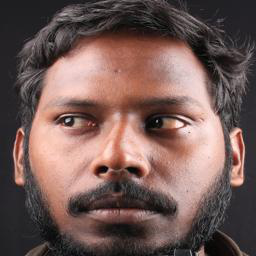

In [668]:
Image.open(img0_tuple[0])

In [669]:
img0 = Image.open(img0_tuple[0])  
img0 = img0.convert("L")  
transform=transforms.Compose([transforms.Resize((100,100)),transforms.ToTensor()])  
img0 = transform(img0)      
 # Taking random image as input to find top 3 similar images 

In [670]:

output1,output2 = model(Variable(img0.unsqueeze(0)),Variable(img0.unsqueeze(0)))                 # changing images to (1,1,100,100) and sending them to siamese model to find the 128 flattened features

In [671]:
pred = output1.cpu().data.numpy()                             #changing the above output to numpy array

In [672]:
label = pickle_model.predict(pred)                                 # predicting the class of a above output using loaded cluster model
print(label[0])

11


In [673]:
import pandas as pd

df = pd.read_csv("labels.csv")

In [674]:
df = df[df['Class'] == (label[0])]

In [675]:
df = df.drop_duplicates(['Paths'])

In [676]:
X2 = df.iloc[:, :-2].values
X1 = pred

In [677]:
Similarities = (np.sqrt(np.sum((np.square(X1-X2)), axis=1)))

In [678]:
Similarities = Similarities.tolist()

In [679]:
paths = df['Paths']

In [680]:
paths = paths.tolist()

In [681]:
result = [(paths[i],Similarities[i]) for i in range(len(paths))]

In [682]:
result = sorted(result,key = lambda x: x[1])[:3]

#Results

In [683]:
result

[('/content/drive/MyDrive/SiameseNetwork_Project/Training/S3/S3_4.JPG',
  0.38498348547989314),
 ('/content/drive/MyDrive/SiameseNetwork_Project/Training/S3/S3_3.JPG',
  0.42254179858013735),
 ('/content/drive/MyDrive/SiameseNetwork_Project/Training/S3/S3_6.JPG',
  0.4254267787373085)]

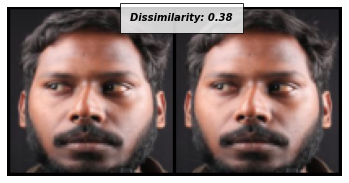

============= The person is S3 ==============


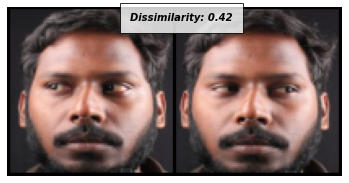

============= The person is S3 ==============


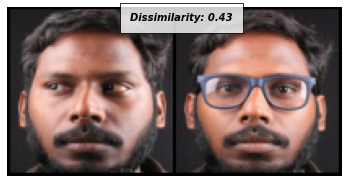

============= The person is S3 ==============


In [684]:
import os
transform=transforms.Compose([transforms.Resize((100,100)),transforms.ToTensor()])
for i in range(len(result)):
  img0 = Image.open(img0_tuple[0])
  img1 = Image.open(result[i][0])
  img0 = transform(img0)
  img1 = transform(img1)
  img0 = img0.unsqueeze(0)
  img1 = img1.unsqueeze(0)
  path=result[i][0]
  name=os.path.dirname(path)
  name=name.split("/")
  concatenated = torch.cat((img0,img1),0)
  imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(result[i][1]))
  print("=============","The person is",name[len(name)-1],"==============")